# Handwritten Digit Classification

## Introduction

The project will implement the Regularized Logistic Regression (one-vs-all algorithm) and Neural Networks to classify the handwritten digit dataset. The objective is to understand how the Neural Networks compared to the Regularized Logistic Regression. The dataset is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset.

The project consists of the following sections,

| Section | Part                                            |Explanation                                    | 
|---------|:-                                               |:-                                             |
| 1       | [Dataset](#section1)                             | Dataset structure |
| 2       | [Define Regularized Logistic Regression Class](#section2)                     | The class serves as a self-built LG algorithm|
| 3       | [Handwritten Digit Classification with LG Class](#section3)     | Evaluate the Regularized LG model          |
| 4       | [Define Neural Networks Class](#section4)     | The class serves as a self-built Neural Network algorithm |
| 5       | [Handwritten Digit Classification with NN Class](#section5)     | Evaluate the NN model         |
| 6       | [Conclusion](#section6)     | Take aways of the project         |

<a id="section1"></a>
## 1:  Dataset 

The dataset used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset. The dataset extension is `.mat`, instead of a text (ASCII) format. The project will use the `scipy.io` module to load the `.mat` dataset into the python environment. 

The dataset contains 5000 training examples. For each example, there is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “*unrolled*” into a 400-dimensional vector. So the X matrix will be,

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

Moreover, the dataset also contains the 5000-dimensional vector `y` that contains labels for the training set. 

<a id="section2"></a>
## 2:  Define a Logistic Regression class 
The pipeline will be,

| Pipeline | Part               |Explanation                       | 
| ---------|:-                  |:-                                |
| 1        | Load the dataset   | Using Numpy                      |
| 2        | Plot the dataset   | Using Matplotlib pyplot          |
| 3        | Sigmoid            | To calculate the $h_{\theta}$    |
| 4        | Cost Function      | Cost of Regularized Logistic Regression  |
| 5        | One-vs-all algorithm | Using Scipy Optimize optimization  |
| 6        | Prediction         | Given $\theta$, return status and its probability  |

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat # to load the .mat dataset
%matplotlib inline

In [2]:
class MultiClassClassification:
    def __init__(self):
        '''
        The method will load the dataset and initialize important value. 
        
        STEPS
        -----
        1. Loading dataset : Refer to the load_data method for details
        '''
        
        self.load_data()
        
    def load_data(self):
        '''
        The method will load the dataset from a CSV file named 'ex3data1.txt'.
        Note: The raw dataset has been shuffled randomly before.
        
        STEPS
        -----
        1. Load the CSV file
        2. Assign the following variables,
            m : number of dataset examples
            X : training set features,
                X[0][0] : 1st pixel of the first image
                X[0][1] : 2nd pixel of the first image
                X[m][n] : nth pixel of the mth image
            y : Handwritten digit labels,
                y=10 : Digit 0
                y=1  : Digit 1
                ...
                y=9  : Digit 9
        '''
        
        # STEP 1
        self.dataset = loadmat(os.path.join('Data', 'ex3data1.mat'))
        
        # STEP 2
        self.X = self.dataset['X']
        self.y = self.dataset['y'].ravel() # Training set labels (0,1, ..., 9)
        
        # set the zero digit to 0, rather than its mapped 10 in this dataset
        # This is an artifact due to the fact that this dataset was used in 
        # MATLAB where there is no index 0
        self.y[self.y == 10] = 0
        
        self.m = self.y.size
        
    def plot_data(self, X, example_width=None, figsize=(10, 10)):
        '''
        The method will select examples randomly and plot it.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing n features values of all examples.
        
        STEPS
        -----
        1. Select 100 examples randomly
        2. Plot the selected examples
        '''
        
        # ====================== STEP 1 ======================
        rand_idx = np.random.choice(self.m, 100, replace=False)
        selected_datapoints = X[rand_idx, :]

        # ====================== STEP 2 ======================
        # Plot the selected_datapoints
        if selected_datapoints.ndim == 2:
            self.m, self.n = selected_datapoints.shape
        elif selected_datapoints.ndim == 1:
            self.n = selected_datapoints.size
            self.m = 1
            selected_datapoints = selected_datapoints[None]  # Promote to a 2 dimensional array
        else:
            raise IndexError('Input X should be 1 or 2 dimensional.')

        example_width = example_width or int(np.round(np.sqrt(self.n)))
        example_height = self.n / example_width

        # Compute number of items to display
        display_rows = int(np.floor(np.sqrt(self.m)))
        display_cols = int(np.ceil(self.m / display_rows))

        fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
        fig.subplots_adjust(wspace=0.025, hspace=0.025)

        ax_array = [ax_array] if self.m == 1 else ax_array.ravel()

        for i, ax in enumerate(ax_array):
            ax.imshow(selected_datapoints[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
            ax.axis('off')

    def sigmoid(self, z):
        '''
        The method will calculate the sigmoid function.
        
        PARAMETERS
        ----------
        z : Numpy array
            A vector of shape (m, 1) from a matrix multiplication of theta and X
            
        RETURNS
        -------
        g : Numpy array
            A vector of shape (m,1) of h_theta
        '''
        
        # Calculate the h_theta
        g = 1 / (1 + np.exp(-z))
        
        return g
    
    def compute_regularized_cost(self, theta, X, y):
        '''
        The method will compute the regularized cost and the gradient. The cost 
        function will be referred later for the scipy optimization algorithm.
        
        PARAMETERS
        ----------
        theta : Numpy array
               A vector of shape (n, 1), containing all thetas.
        X : Numpy array
            A matrix of shape (m, n), containing all examples' features values
            and unit bias
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
            
        RETURNS
        -------
        J : float
            Given the theta, return the cost of the model
        grad : Numpy array
            A vector of shape (n,1), containing the gradient of the model
            
        STEPS
        -----
        1. Calculate the sigmoid function
        2. Calculate the cost and gradient
        '''
        
        # ====================== STEP 1 ======================
        grad = np.zeros(theta.shape)
        # convert labels to ints if their type is bool
        if y.dtype == bool:
            y = y.astype(int)
        z = np.dot(X,theta)
        h_theta = self.sigmoid(z)
        
        # ====================== STEP 2 ======================
        J = (1/self.m) * np.sum(np.dot(-y, np.log(h_theta)) - np.dot((1-y), np.log(1-h_theta))) 
        + (self.lambda_ / (2*self.m)) * np.sum(np.square(theta[1:]))

        grad = (1/self.m) * np.dot((h_theta - y), X)
        grad[1:] = grad[1:] + (self.lambda_/self.m) * theta[1:]        

        return J, grad

    def one_vs_all(self, X, y, num_labels, lambda_, maxiter):
        '''
        The method uses a Conjugate Gradient algorithm (CG) in the Scipy 
        Optimization. Please refer to the Review section.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples' labels
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
        num_labels : int
            Number of labels of the datasets
        lambda_ : float
            The hyperparameter for regularization  
        maxiter : int
            Number of max iterations allowed for the scipy.optimize

        RETURNS
        -------
        all_theta : Numpy array
            A matrix of shape (K, n+1), for K is number of classes.
            The matrix contains optimized thetas for each K from CG.
            
        STEPS
        -----
        1. Add bias term to the features' values
        2. Define important values
        3. Scipy optimization
        '''
        
        # STEP 1
        bias_unit = np.ones((X.shape[0],1))
        X_with_bias = np.hstack((bias_unit,X))
        
        # STEP 2
        all_theta = np.zeros((num_labels, self.n + 1))
        self.initial_theta = np.zeros(X_with_bias.shape[1])
        initial_theta = self.initial_theta.copy()
        self.lambda_ = lambda_
        
        # STEP 3
        options = {'maxiter' : maxiter}
        # Solve using Scipy Optimization to obtain thetas for each
        # label
        for label in np.arange(num_labels):
            res = optimize.minimize(self.compute_regularized_cost,
                                    initial_theta,
                                    (X_with_bias, (y == label)),
                                    jac=True,
                                    method='CG',
                                    options=options)
            all_theta[label] = res.x
        return all_theta
    
                                    
    def predict(self, X, theta):
        '''
        The method will predict the digits given the X and thetas.
        Moreover, calculate the predictions' probability.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples features'
            values
        theta : Numpy array
            A vector of shape (n, 1), containing all thetas.
            
        RETURNS
        -------
        probability : Numpy array
                    A vector of shape (m, 1), containing the labels' probability
        qa_status : Numpy array
                    A vector of shape (m,1), containing the digits' label 
                        
        STEPS
        -----
        1. Add bias term to the X
        2. Calculate the sigmoid function
        3. Assign the prediction based on the probability threshold (0.5)
        '''
        
        # STEP 1
        bias_unit = np.ones((X.shape[0],1))
        X_with_bias = np.hstack((bias_unit,X))
        
        # STEP 2
        z = np.dot(X_with_bias,theta.T)
        probability = self.sigmoid(z)
        
        # STEP 3
        # If probability is higher or equal to 0.5,
        # set the status as admitted
        label = np.argmax(probability, axis = 1)
        
        return probability, label

<a id="section3"></a>
## 3:  Handwritten Digit Classification with LG Class 
In section 3, we will predict the Digit using the Regularized Logistic Regression class and one-vs-all algorithm.

In [3]:
handwritten_digit = MultiClassClassification()
X = handwritten_digit.X.copy()
y = handwritten_digit.y.copy()

The subset of the dataset is illustrated below,

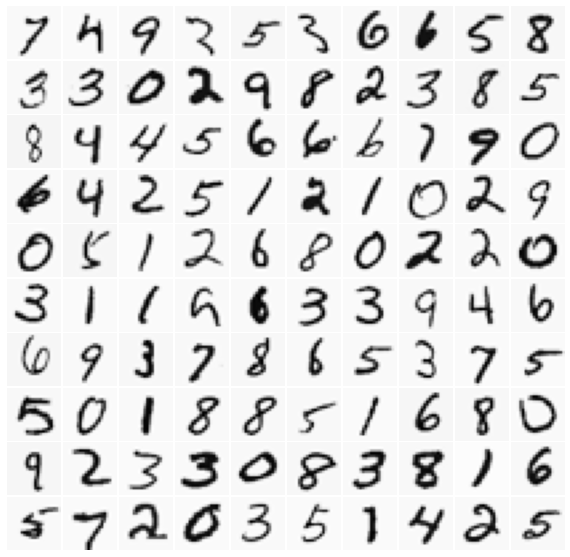

In [4]:
handwritten_digit.plot_data(X)
plt.show()

Begin the optimization process using `scipy.optimize`,

In [5]:
num_labels = 10
lambda_ = 0.1
maxiter = 100
all_theta = handwritten_digit.one_vs_all(X, y, num_labels, lambda_, maxiter)

The `scipy_optimize` return the `theta` with the lowest cost. Let's evaluate the model accuracy,

In [6]:
p, predicted_digit = handwritten_digit.predict(X, all_theta)

print('Model Accuracy: {:.2f} %'.format(np.mean(predicted_digit == y) * 100))

Model Accuracy: 96.12 %


To summarize, the model was created using the Regularized Logistic Regression and One-vs-all algorithm. The model has the accuracy of **96.12%** to classify the handwritten digits.

<a id="section4"></a>
## 4:  Define a Neural Networks Class
In this section, we will define a Neural Network class to classify the handwritten digit. The NN architecture is as follows,

![Neural network](Figures/neuralnetwork.png)

The architecture has 3 layers: an input layer, a hidden layer and an output layer. The input layer contains 400 units (20x20 pixels). The hidden layer has 25 hidden units. The output layer has 10 outputs. 

In this project, the weights ($\Theta^{(1)}$, $\Theta^{(2)}$) are already obtained from the backpropagation. The NN class will only implement the forwardpropagation to predict using the existing weights.

The pipeline will be,

| Pipeline | Part               |Explanation                       | 
| ---------|:-                  |:-                                |
| 1        | Load the weights   | Using scipy.io                      |
| 2        | Sigmoid            | To calculate the $h_{\theta}$    |
| 3        | Prediction         | Given $\theta$, return the label  |

In [7]:
class NeuralNetworkClassification:
    def __init__(self):
        '''
        Load the data and initialize the NN architecture pars.
        '''
        
        self.load_weight()
        self.input_layer_size  = 400
        self.hidden_layer_size = 25
        self.num_labels = 10
        
    def load_weight(self):
        '''
        Load the weights for the NN architecture from backprop. 
        '''
        
        self.weights = loadmat(os.path.join('Data', 'ex3weights.mat'))
        self.Theta1, self.Theta2 = self.weights['Theta1'], self.weights['Theta2']
        
        # swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
        # since the weight file ex3weights.mat was saved based on MATLAB indexing
        self.Theta2 = np.roll(self.Theta2, 1, axis=0)
        
    def sigmoid(self, z):
        '''
        Calculate the sigmoid function.
        
        Parameters
        ----------
        z : Numpy array
            A vector of shape (m, 1) from a matrix multiplication of theta and X
            
        Returns
        -------
        g : Numpy array
            A vector of shape (m,1) of h_theta
        '''
        
        # Calculate the h_theta
        g = 1 / (1 + np.exp(-z))
        
        return g
        
    def predict(self, X):
        '''
        Given the X and thetas, calculate the whether the QA status will 
        be accepted (qa_status = 1) or not (qa_status = 0). Moreover, 
        calculate probability of the prediction being correct.
        
        X : Numpy array
            A matrix of shape (m, n), containing all examples features's
            values and unit bias
        theta : Numpy array
            A vector of shape (n+1, 1), containing all thetas.

        Returns
        -------
        probability : Numpy array
                    A vector of shape (m, 1), containing the label
                    probability
        label : Numpy array
                A vector of shape (m,1), containing the label of
                the digits
        '''
        # Make sure the input has two dimensions
        if X.ndim == 1:
            X = X[None]  # promote to 2-dimensions
        
        # Add bias term to the matrix X
        bias_unit = np.ones((X.shape[0],1))
        X_with_bias = np.hstack((bias_unit,X))
        
        # layer 2
        a2 = self.sigmoid(np.dot(X_with_bias, self.Theta1.T))
        add_bias_unit_a2 = np.ones((a2.shape[0],1))
        a2 = np.hstack((add_bias_unit_a2,a2)) 
        
        #layer3
        a3 = self.sigmoid(np.dot(a2, self.Theta2.T))
        label = np.argmax(a3, axis = 1)
        
        return label

<a id="section5"></a>
## 5:  Handwritten Digit Classification with NN Class 
In section 4, we will predict the Digits label using `NeuralNetworkClassification` class. After the `NeuralNetworkClassification` class has been defined, let's initiate the model

In [8]:
neural_network = NeuralNetworkClassification()

After initiated, let's predict the labels using existing weights.

In [9]:
pred = neural_network.predict(X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Based on existing weights, the current Neural Network model has the accuracy of **97.5%**, slightly higher compared to the previous section (**96.12%**). On the next project, we will implement a backpropagation on `NeuralNetworkClassification` to obtain the weights.

<a id="section6"></a>
## 6:  Conclusion
In this project, we have successfully implemented One-vs-all algorithm in Regularized Logistic Regression. The model has the accuracy of **96.12%**. Moreover, the `NeuralNetworkClassification` class also used to classify the label. It uses only forwardpropagation (to predict the label) since the weights have been provided. The model has the accuracy of **97.5%**. slightly higher than the `RegularizedLogisticRegression` model. 